In [32]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Nice plotting defaults
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["axes.grid"] = True
sns.set_context("notebook")


In [33]:
DATA_PATH = "data/asu.tsv"
df = pd.read_csv(DATA_PATH, sep=r"\s+", comment="#", engine="python")

# Drop "unit" and "-----" rows
mask_units = df.iloc[0].astype(str).str.contains("mag|deg|mas", case=False).any()
mask_dashes = df.iloc[0].astype(str).str.fullmatch("-+").any()
if mask_units:
    df = df.iloc[1:].copy()
if mask_dashes:
    df = df.iloc[1:].copy()

# Also drop any dashed rows within the table (just in case)
df = df[~df.iloc[:, 0].astype(str).str.match("^-+$")].copy()

# Convert known numeric columns safely
numeric_cols = [c for c in ["HIP", "Vmag", "RAICRS", "DEICRS", "Plx", "B-V"] if c in df.columns]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Keep only valid rows
df = df.dropna(subset=["Vmag", "Plx"]).reset_index(drop=True)

print(df.shape)
print("Columns:", list(df.columns))
df.head()


(99767, 9)
Columns: ['HIP', 'Vmag', 'RAICRS', 'DEICRS', 'Plx', 'B-V', 'Notes', '_RA.icrs', '_DE.icrs']


,HIP,Vmag,RAICRS,DEICRS,Plx,B-V,Notes,_RA.icrs,_DE.icrs
0,1,9.10,0.000912,1.089013,3.54,0.482,000.00089921,+01.08900875,None
1,2,9.27,0.003797,-19.498837,21.90,0.999,000.00426461,-19.49883971,None
2,3,6.61,0.005008,38.859286,2.81,-0.019,000.00502431,+38.85927901,None
3,4,8.06,0.008382,-51.893546,7.75,0.370,000.00862924,-51.89354573,None
4,5,8.55,0.009965,-40.591224,2.87,0.902,000.00997344,-40.59120235,None


In [34]:
COL_PLX = "Plx"      # parallax in mas
COL_V   = "Vmag"     # apparent V magnitude
COL_BV  = "B-V"      # color index (may have NaNs)

# keep rows with positive parallax (needed for distance)
df = df.copy()
df = df[pd.to_numeric(df[COL_PLX], errors="coerce") > 0].copy()

In [35]:
df.corr(numeric_only=True)

,HIP,Vmag,RAICRS,DEICRS,Plx,B-V
HIP,1.000000,-0.006492,0.999257,-0.036330,-0.002867,0.047616
Vmag,-0.006492,1.000000,-0.007143,0.010845,-0.036500,0.148400
RAICRS,0.999257,-0.007143,1.000000,-0.036163,-0.003130,0.047027
DEICRS,-0.036330,0.010845,-0.036163,1.000000,0.017637,-0.013492
Plx,-0.002867,-0.036500,-0.003130,0.017637,1.000000,0.021178
B-V,0.047616,0.148400,0.047027,-0.013492,0.021178,1.000000


In [36]:
# distance in parsecs
df["distance_pc"] = 1000.0 / df[COL_PLX]  # parallax is in milliarcseconds

# absolute magnitude Mv = m - 5*log10(d/10)
df["Mv"] = df[COL_V] - 5 * (np.log10(df["distance_pc"]) - 1)

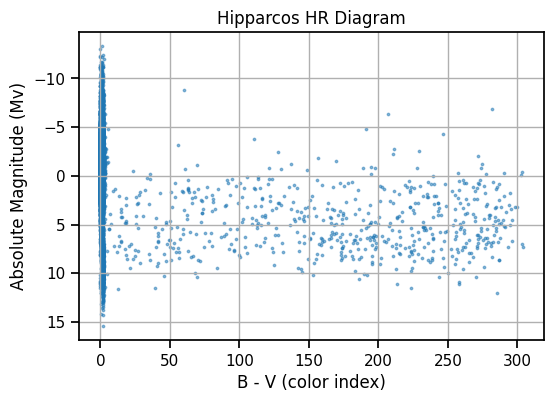

In [37]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df[COL_BV], df["Mv"], s=3, alpha=0.5)
ax.set_xlabel("B - V (color index)")
ax.set_ylabel("Absolute Magnitude (Mv)")
ax.set_title("Hipparcos HR Diagram")
ax.invert_yaxis()  # brighter at top
plt.show()

In [38]:
features = ["Mv", "distance_pc"]
if COL_BV in df.columns and df[COL_BV].notna().any():
    features = [COL_BV, "Mv", "distance_pc"]

X = df[features].copy()
X["log10_distance"] = np.log10(X["distance_pc"])
X = X.drop(columns=["distance_pc"])
X = X.replace([np.inf, -np.inf], np.nan).dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features used:", list(X.columns))
print("X_scaled shape:", X_scaled.shape)

Features used: ['B-V', 'Mv', 'log10_distance']
X_scaled shape: (95984, 3)


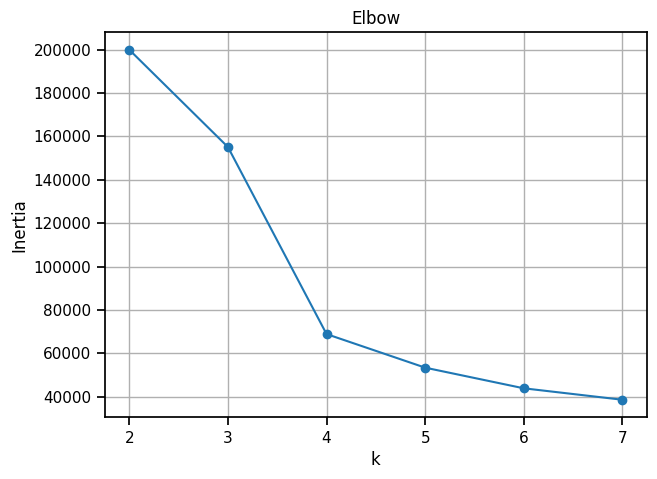

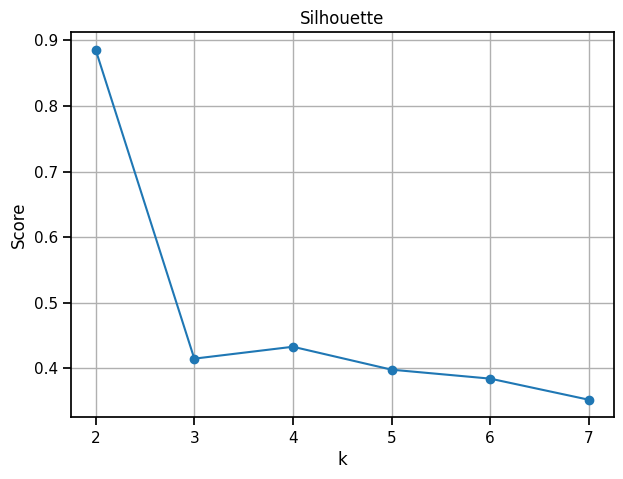

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

ks = range(2, 8)
inertias, sils = [], []
for k in ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=79)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, labels))

plt.plot(list(ks), inertias, "o-"); plt.title("Elbow"); plt.xlabel("k"); plt.ylabel("Inertia"); plt.show()
plt.plot(list(ks), sils, "o-"); plt.title("Silhouette"); plt.xlabel("k"); plt.ylabel("Score"); plt.show()

from plots -> k=4

In [43]:
from sklearn.cluster import MiniBatchKMeans

k_value = 4

# MiniBatchKMeans for speed with large data
km_model = MiniBatchKMeans(
    n_clusters=k_value,
    random_state=79,
    batch_size=4096,
    n_init=10,
    max_iter=200
)
labels = km_model.fit_predict(X_scaled)

df_work = df.loc[X.index].copy()
df_work["cluster"] = labels 

print(df_work["cluster"].value_counts().sort_index())
display(df_work.groupby("cluster")[["Mv", "B-V"]].mean())

cluster
0    43742
1    27843
2    10437
3    13962
Name: count, dtype: int64


,Mv,B-V
cluster,,
0,0.918119,0.835825
1,3.129732,0.546905
2,5.744769,9.098814
3,-1.819806,1.656310


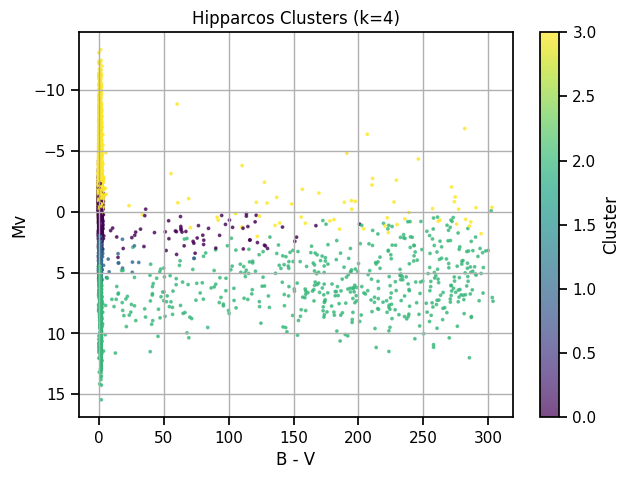

In [44]:
plt.scatter(df_work["B-V"], df_work["Mv"], c=df_work["cluster"], s=3, alpha=0.7, cmap="viridis")
plt.gca().invert_yaxis()
plt.xlabel("B - V"); plt.ylabel("Mv"); plt.title("Hipparcos Clusters (k=4)")
plt.colorbar(label="Cluster"); plt.show()


## 🧭 Interpreting Clusters (Quick Guide)

- **Lower Mv (top of HR diagram) = intrinsically brighter** stars.
- **Higher B–V = redder/cooler**; **Lower B–V = bluer/hotter**.
- Expect clusters roughly corresponding to:
  - **Main sequence** (diagonal band)
  - **Red giants** (upper-right)
  - **White dwarfs** (lower-left; low luminosity but blue)

Use `groupby("cluster_km").mean()` and compare typical B–V / Mv ranges to label your clusters in a table.
